In [1]:
from game import Game
from ai import SplendorAI
from player import get_phase_parameters
from constants import *
from datetime import datetime
# from player import get_phase_parameters
import sys
from collections import defaultdict
from collections import Counter
import pickle
import objgraph



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# simply used to initialize players
base_game = Game(id=0, n_players=4)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12338458494319611165
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9866775757
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5141781939982434597
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [5]:
# temperature will decrease over time, but bump up for each new phase
def calculate_temperature(round):
    return 4/(2.5+round) /(1.5+round % 4)/(1+4*(round>=20))

In [6]:
# constants to define; default
NETWORK_HYPERPARAMETERS = {
    # player input
    'player_funnel_layers': [15,12,10],
    'reserved_funnel_layers': [12,10,],
    'inject_reserved_at_player_funnel_index': 1, # 0 same as input, 1 = as first layer, etc.
    'card_funnel_layers': [12,12,8],
    # game input
    'game_funnel_layers': [15, 12, 10],
    'game_objective_funnel_layers': [10, 8],
    'game_card_funnel_layers': [15, 12, 10],
    # overall, slightly increased from default
    'main_dense_layers': [84, 36, 15], #this is when everything is combined

    # output layers
    # this does not include the win layer
    'output_layers': [
        {
            'name': 'Q1',
            'lag': 1,
            'score': 1,
            'discount': 0.1,
            'gems': 0.01,

        },
        {
            'name': 'Q3',
            'lag':  3,
            'score': 1,
            'discount': 0.1,
            'gems': 0,
        },
        {
            'name': 'Q5',
            'lag': 5,
            'score': 1,
            'discount': 0.05,
            'gems': 0,
        },
    ],
}

def get_phase_parameters(phase):
    """
    training will be divided into 5 phases

    """
    if phase==1:
        return {
            'Q1': 0.5,
            'Q3': 0.3,
            'Q5': 0.15,
            'win': 0.05,
        }
    elif phase==2:
        return {
            'Q1': 0.4,
            'Q3': 0.25,
            'Q5': 0.2,
            'win': 0.15,
        }
    elif phase==3:
        return {
            'Q1': 0.25,
            'Q3': 0.25,
            'Q5': 0.25,
            'win': 0.25,
        }
    elif phase==4:
        return {
            'Q1': 0.15,
            'Q3': 0.2,
            'Q5': 0.35,
            'win': 0.3,
        }
    elif phase==5:
        return {
            'Q1': 0.05,
            'Q3': 0.1,
            'Q5': 0.35,
            'win': 0.50,
        }
    elif phase==6:
        return {
            'Q1': 0.03,
            'Q3': 0.1,
            'Q5': 0.22,
            'win': 0.75
        }

In [7]:
def make_ai_name(player):
    return('run6_player_%s_round_' % player.id)

In [8]:
def set_temperature_and_phase(player, i):
    phase = min(6, i // 4 + 1)
    temperature = calculate_temperature(i)
    phase_params = get_phase_parameters(phase)
    player.set_temperature(temperature)
    player.set_decision_weighting(phase_params)
    

In [9]:
players = base_game.players
# (p0, p1, p2, p3) : results
game_data = defaultdict(list)
win_records = defaultdict(Counter)
game_counter = 0
# let's look at half of the models, because many of them are similar and we don't want to waste too much time
model_indices = list(range(21))[::5]

In [10]:
for target_player_id in range(4):
    print('PLAYER %s ROUNDS' % target_player_id)
    if target_player_id==0:
        continue
    for other_player_i in model_indices:
        if target_player_id==1 and other_player_i < 10:
            continue
        # set other player levels
        for pid in range(4):
            if pid != target_player_id:
                ai_name = make_ai_name(players[pid])
                players[pid].ai.load_models(ai_name, other_player_i)
                set_temperature_and_phase(players[pid], other_player_i)
        for target_player_i in model_indices:
            set_temperature_and_phase(players[target_player_id], target_player_i)
            i_tuple = [other_player_i for _ in range(4)]
            i_tuple[target_player_id] = target_player_i
            i_tuple = tuple(i_tuple)
            print(i_tuple)
            # set base player level
            ai_name = make_ai_name(players[target_player_id])
            players[target_player_id].ai.load_models(ai_name, target_player_i)
            set_temperature_and_phase(players[target_player_id], target_player_i)
            for iteration in range(32):
                new_game = Game(id=game_counter, players=players)
                new_game.run()
                sys.stdout.write('.')
                game_data[i_tuple].append(new_game.copy_plain_data_for_self_and_players())
                win_records[i_tuple].update({pid:1*players[pid].win for pid in range(4)})
                game_counter+=1
            print('WIN RECORDS: ', win_records[i_tuple])
            # players don't need to keep track of history, really...
            for pid in range(4):
                players[pid].reset(reset_extended_history=True)


PLAYER 0 ROUNDS
PLAYER 1 ROUNDS
(10, 0, 10, 10)
................................WIN RECORDS:  Counter({3: 15, 0: 10, 2: 6, 1: 1})
(10, 5, 10, 10)
................................WIN RECORDS:  Counter({2: 11, 1: 9, 3: 9, 0: 3})
(10, 10, 10, 10)
................................WIN RECORDS:  Counter({1: 11, 3: 10, 0: 7, 2: 4})
(10, 15, 10, 10)
................................WIN RECORDS:  Counter({3: 13, 0: 8, 2: 6, 1: 5})
(10, 20, 10, 10)
................................WIN RECORDS:  Counter({2: 12, 0: 7, 3: 7, 1: 6})
(15, 0, 15, 15)
................................WIN RECORDS:  Counter({0: 11, 2: 10, 3: 8, 1: 3})
(15, 5, 15, 15)
................................WIN RECORDS:  Counter({0: 14, 2: 7, 3: 6, 1: 5})
(15, 10, 15, 15)
................................WIN RECORDS:  Counter({2: 11, 0: 9, 3: 8, 1: 4})
(15, 15, 15, 15)
................................WIN RECORDS:  Counter({0: 11, 3: 10, 2: 6, 1: 5})
(15, 20, 15, 15)
................................WIN RECORDS:  Counter({1: 10, 2: 10, 

KeyboardInterrupt: 

In [27]:
with open('run_6_matchup_runs2.dat', 'wb') as f:
    pickle.dump(game_data, f)
    
with open('run_6_matchup_win_records2.dat', 'wb') as f:
    pickle.dump(win_records, f)

In [28]:
obj = players[0].ai
for attr in dir(obj):
    if hasattr(getattr(obj, attr), '__len__'):
        print(attr, ' ', len(getattr(obj, attr)))

__dict__   13
__module__   2
game_cards_inputs   3
game_objective_inputs   5
hyperparameters   9
model_inputs   34
player_inputs   4
q_networks   3
reserved_inputs   4


In [29]:
import gc
gc.collect()
import inspect

import resource
print('Memory usage: %s (kb)' % resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)


Memory usage: 11610892 (kb)


In [44]:
import tensorflow as tf
from keras import backend as K
tf.reset_default_graph()
K.clear_session()

In [11]:
objgraph.show_most_common_types(limit=50)

tuple                         18601478
list                          4704549
dict                          1942028
Dimension                     700124
Tensor                        539621
TensorShape                   539392
Operation                     522551
ColorCombination              99633
function                      94111
cell                          65840
Node                          32598
Variable                      17130
InputLayer                    7956
weakref                       7347
type                          4524
Zeros                         4204
Dense                         4182
InputSpec                     4182
VarianceScaling               4182
getset_descriptor             3224
set                           2710
Concatenate                   2706
wrapper_descriptor            2503
builtin_function_or_method    2395
property                      2163
method_descriptor             2067
ModuleSpec                    1788
module                        17

In [45]:
objgraph.show_most_common_types(limit=50)

tuple                         18537150
list                          4679615
dict                          1682795
Dimension                     700124
Tensor                        539625
TensorShape                   539396
Operation                     522555
Node                          32569
function                      29623
Variable                      17130
InputLayer                    7956
weakref                       6002
Zeros                         4204
Dense                         4182
InputSpec                     4182
VarianceScaling               4182
type                          3311
getset_descriptor             3226
Concatenate                   2706
set                           2685
cell                          2563
wrapper_descriptor            2503
builtin_function_or_method    2367
property                      2166
method_descriptor             2067
ModuleSpec                    1789
module                        1788
SourceFileLoader              1623

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


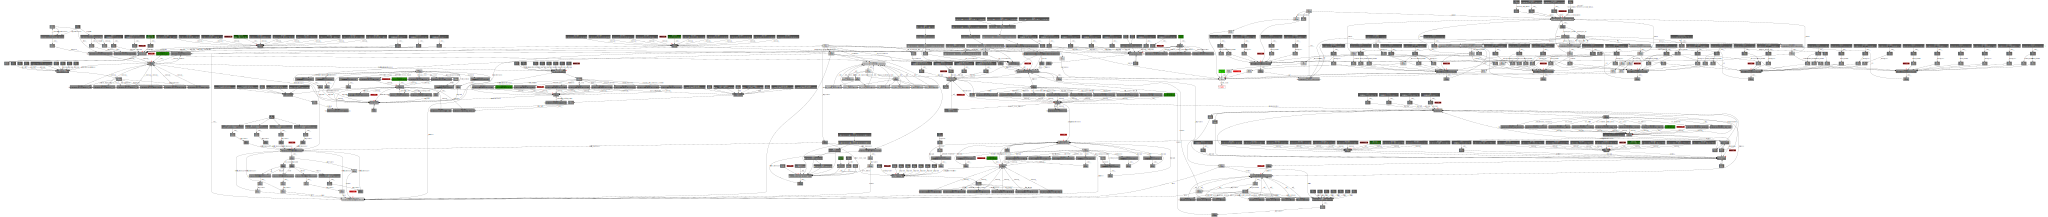

In [13]:
objgraph.show_backrefs(game_data, max_depth=10)

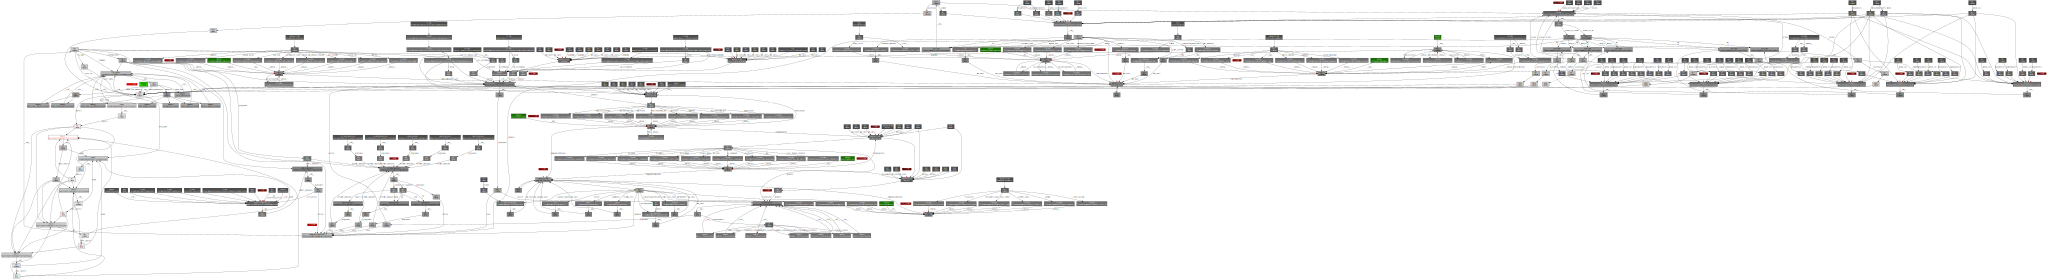

In [14]:
objgraph.show_backrefs(players[0], max_depth=10)

In [15]:
grph = objgraph.show_backrefs(players[0], max_depth=10, filename='/ntfsl/workspace/splendor_ai/player_objgraph.png')

In [26]:
print(type(grph))
grph.render('player_graph.png')

<class 'graphviz.files.Source'>


'player_graph.png.pdf'

In [53]:
grph2 = objgraph.show_refs(tf, max_depth=10)
grph2.render('graph2')

'graph2.pdf'

In [ ]:
import keras
import tensorflow
from copy import deepcopy
# tensorflow.reset_default_graph()
game_data_copy = deepcopy(game_data)
del game_data

# Test multiple runs of games (old code for reference in markdown)

```

n_rounds = 22
n_sets_per_round = 2
n_simulations_per_set = 100

start_time = datetime.now()
for i in range(n_rounds):
    print('ON ROUND', i)
    for j in range(n_sets_per_round):
        set_start_time = datetime.now()
        for k in range(n_simulations_per_set):
            # if (i==0) and (j==0):
            #    # soft restart
            #    break
            new_game = Game(id=i*200 + j*100+k, players=players)
            stalemate = new_game.run()  
            # stalemates should be extraordinarily rare and pretty much nonexistent
            if stalemate: 
                very_long_game = new_game
                print('teaching ai not to stalemate')
                for player in players:
                    player.transfer_history_to_ai()
                    player.ai.train_models(verbose=0,n_epochs=4)
            sys.stdout.write('.')
            sys.stdout.flush()
            # record historic game data for each set
            game_data[(i,j)].append(new_game.copy_plain_data_for_self_and_players())
        set_stop_time = datetime.now()
        duration = (set_start_time-set_stop_time).seconds
        for player in players:
            player.transfer_history_to_ai()
            player.ai.train_models(verbose=0, n_epochs=12)
        set_durations[(i,j,k)] = duration
        print('/')
        sys.stdout.flush()
        avg_game_length = np.mean([x['game']['turn'] for x in game_data[(i,j)]])
        print('R/S %d/%d AVERAGE GAME LENGTH: ' % (i, j), avg_game_length)
        avg_cards_purchased = np.mean([
            [
                pdata['n_cards'] 
                for pdata in x['players'].values()
            ] 
            for x in game_data[(i,j)]
        ]
        )
        print('R/S %d/%d AVERAGE CARDS PURCHASED: ' % (i, j), avg_cards_purchased)
        # calculate win rates
        player_data = [x['players'] for x in game_data[(i,j)]]
        win_values = [[player_data[idx][pid]['win'] for idx in range(100)] for pid in range(4)]
        win_rates = [np.mean(v) for v in win_values]
        print('WIN RATES: ', str(win_rates))
                             
    for player in players:
        player.reset(reset_extended_history=True)
    
    temperature = calculate_temperature(i)
    
    for p_i, player in enumerate(players):
        player.temperature = temperature
        player.decision_weighting = get_phase_parameters(phase)
        model_name = 'run6_player_%s_round_' % str(p_i)
        player.ai.save_models(model_name, index=i)
    
    
stop_time = datetime.now()
for time in [start_time, stop_time]:
    print(time.strftime('%x %X'))
    
# save historic data
import pickle
with open('run_6_game_data.dat', 'wb') as f:
    pickle.dump(game_data, f)
    
with open('run_6_duration_data.dat', 'wb') as f:
    pickle.dump(set_durations, f)
    
```

In [ ]:
# players[0].ai.load_models('run6_player_0_round_', 1)

In [46]:
from collections import Mapping, Container 
from sys import getsizeof

def deep_getsizeof(o, ids): 

    d = deep_getsizeof
    if id(o) in ids:
        return 0

    r = getsizeof(o)
    ids.add(id(o))

    if isinstance(o, str) or isinstance(0, bytes):
        return r
    
    if isinstance(o, np.ndarray):
        return r

    if isinstance(o, Mapping):
        return r + sum(d(k, ids) + d(v, ids) for k, v in o.items())

    if isinstance(o, Container):
        return r + sum(d(x, ids) for x in o)

    return r

# deep_getsizeof(players[0].extended_serialized_action_history[0], set())

# for k in list(locals().keys()):
#    v = locals()[k]
#    size = deep_getsizeof(v, set())
#    if size > 100000:
#        print(k, ':', size)
print(deep_getsizeof((1,2,3,4), set()))

192


In [ ]:
deep_getsizeof(win_records, set())

In [34]:
for player in players:
    del player 
    
del players

In [35]:
del new_game

In [36]:
del game_data

In [42]:
del sess

In [43]:
del base_game

In [47]:
del i_tuple

In [49]:
global_vars = list(globals().keys())
global_vars

['_18',
 'quit',
 '_13',
 '_i13',
 '_i41',
 'other_player_i',
 '_39',
 '_i17',
 'PURE_BLANK_CARD_SERIALIZATION',
 'pid',
 '_26',
 '_i47',
 '_14',
 '_i20',
 '_i42',
 '_ii',
 'defaultdict',
 'inspect',
 'CARD_CSV_FILENAME',
 '_19',
 'TIER_3_CARDS',
 'game_counter',
 'set_temperature_and_phase',
 '_i35',
 '_i2',
 '_37',
 '_i9',
 '_12',
 'GOLD_STOCKPILE_AMOUNT',
 'COLOR_ORDER',
 'Container',
 'Game',
 '_i30',
 'TIER_1_CARDS',
 'get_ipython',
 'COST_COLOR_ORDER',
 'json',
 '_i15',
 '_i45',
 '_i34',
 'grph',
 '_i26',
 'SplendorAI',
 'obj',
 'LOAD_CARDS',
 'GEMS_PILE',
 '_i18',
 'make_blank_card',
 'Counter',
 '_i25',
 '_i21',
 '_',
 '_ih',
 '_i28',
 'calculate_temperature',
 'Out',
 '_i38',
 '_i33',
 '_i23',
 '_i16',
 '_20',
 'deep_getsizeof',
 '_i6',
 'win_records',
 'gc',
 '_i3',
 '_22',
 '_iii',
 'attr',
 'print_function',
 'iteration',
 '_i36',
 'ai_name',
 'In',
 '__builtin__',
 'NETWORK_HYPERPARAMETERS',
 '_i31',
 'get_phase_parameters',
 '__spec__',
 '_i22',
 'getsizeof',
 '__name__',

# NOTES

Runs are complete. Data can be analyzed in a different environment. Tweaks may be made for future runs based on simulation results from loaded models.